In [1]:
import numpy as np
import glob
import json
import xarray as xr
import geopandas as gpd
import requests
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
domain = 'WY'
with open('/nfs/attic/dfh/Aragon2/CSOdata/CSO_domains.json') as f:
    domains = json.load(f)

#Snotel bounding box
Bbox = domains[domain]['Bbox']
latmax = Bbox['latmax']
latmin = Bbox['latmin']
lonmax = Bbox['lonmax']
lonmin = Bbox['lonmin']

In [3]:
#CSO data path
CSOpath = 'cso-data.geojson'
#assimilation files 
assimPath = '/nfs/attic/dfh/Aragon2/CSOassim/'+domain+'/'

#path to CSO domain
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()
    
#start date    
st = domains[domain]['st']
#end date
ed = domains[domain]['ed']

#Snotel bounding box
Bbox = domains[domain]['Bbox']

# CSO projection
stn_proj = domains[domain]['stn_proj']

# CSO projection
mod_proj = domains[domain]['mod_proj']

#Issue CSO API observations request and load the results into a GeoDataFrame
params = {
  "bbox": f"{Bbox['lonmin']},{Bbox['latmax']},{Bbox['lonmax']},{Bbox['latmin']}",
  "start_date": st,
  "end_date": ed,
  "format": "geojson",
  "limit": 5000,
}

csodata_resp = requests.get("https://api.communitysnowobs.org/observations", params=params)
csodatajson = csodata_resp.json()

gdf = gpd.GeoDataFrame.from_features(csodatajson, crs=stn_proj)

gdf

,geometry,id,author,depth,source,timestamp,elevation
0,POINT (-110.96955 43.50077),YvtYk5nZ,Grant Henarie,47.0,SnowPilot,2020-12-15T22:00:00.000Z,2583.323730
1,POINT (-110.95316 43.49560),RHFMtCB0,Lynne Wolfe,89.0,SnowPilot,2020-12-15T20:00:00.000Z,2541.762939
2,POINT (-110.83179 43.62928),vPeIuJm1,Nancy Bockino,90.0,SnowPilot,2020-12-15T19:00:00.000Z,2400.353760
3,POINT (-110.87692 43.58721),4bMDgkOw,Dan Corn,115.0,SnowPilot,2020-12-15T16:50:00.000Z,2964.886963
4,POINT (-110.87884 43.58034),N1WOeAD3,Tim Petrick,150.0,SnowPilot,2020-12-14T17:00:00.000Z,2878.567627
...,...,...,...,...,...,...,...
627,POINT (-110.94512 43.50662),ZieRtWwG,Mike Hardaker,220.0,SnowPilot,2017-01-09T03:46:30.000Z,2681.205078
628,POINT (-110.15553 44.46178),ZsTR7G2t,John McCurdy,165.0,SnowPilot,2016-12-23T17:46:29.000Z,2770.274658
629,POINT (-110.87574 43.57965),Fqnv6kiF,Bill Anderson,142.0,SnowPilot,2016-12-21T13:28:18.000Z,2823.013916
630,POINT (-110.87301 43.59553),t0HyUg9o,Mike Rheam,32.0,SnowPilot,2016-12-02T22:20:07.000Z,2997.033203


In [4]:
ds = xr.merge([ xr.open_dataset(f).sel(lat=slice(latmin, latmax),lon=slice(lonmin,lonmax)) for f in glob.glob('/nfs/attic/dfh/data/UA_SWE/*nc')])
ds

<xarray.Dataset>
Dimensions:   (lat: 53, lon: 40, time: 14245, time_str_len: 11)
Coordinates:
  * time      (time) datetime64[ns] 1981-10-01 1981-10-02 ... 2020-09-30
  * lat       (lat) float32 42.375 42.416668 42.458332 ... 44.5 44.541668
  * lon       (lon) float32 -111.125 -111.083336 ... -109.541664 -109.5
Dimensions without coordinates: time_str_len
Data variables:
    crs       |S1 b''
    time_str  (time_str_len, time) object b'0' b'0' b'0' b'0' ... b'0' b'0' b'0'
    SWE       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    DEPTH     (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


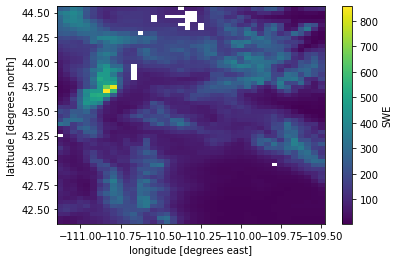

In [5]:
avswe = ds.SWE.mean(dim='time')
avswe.plot()

In [6]:
test=ds.sel(lat=gdf.geometry.y.values[627],lon=gdf.geometry.x.values[627],method='nearest')
test

<xarray.Dataset>
Dimensions:   (time: 14245, time_str_len: 11)
Coordinates:
  * time      (time) datetime64[ns] 1981-10-01 1981-10-02 ... 2020-09-30
    lat       float32 43.5
    lon       float32 -110.958336
Dimensions without coordinates: time_str_len
Data variables:
    crs       |S1 b''
    time_str  (time_str_len, time) object b'0' b'0' b'0' b'0' ... b'0' b'0' b'0'
    SWE       (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    DEPTH     (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

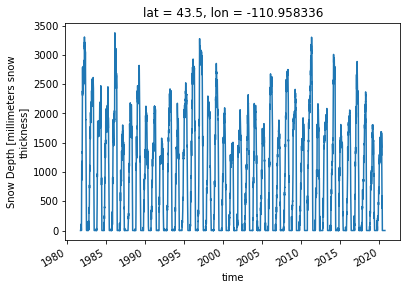

In [7]:
test.DEPTH.plot()

In [8]:
df = test.DEPTH.to_dataframe()

In [9]:
#dataframe by year 
pv = pd.pivot_table(df, index=df.index.dayofyear, columns=df.index.year, values='DEPTH', aggfunc='sum')
pv = pv.drop([366])
pv


time,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
time,,,,,,,,,,,,,,,,,,,,,
1,NaN,2358.0,1617.0,1772.0,1995.0,1461.0,925.0,1148.0,1741.0,907.0,...,1829.0,1029.0,1545.0,1180.0,1350.0,1273.0,1372.0,866.0,982.0,758.0
2,NaN,2325.0,1593.0,1773.0,1960.0,1489.0,1071.0,1105.0,1785.0,951.0,...,1766.0,1036.0,1521.0,1170.0,1348.0,1283.0,1348.0,858.0,971.0,896.0
3,NaN,2361.0,1577.0,1736.0,1918.0,1498.0,1041.0,1116.0,1759.0,976.0,...,1816.0,1011.0,1528.0,1168.0,1343.0,1208.0,1344.0,852.0,839.0,777.0
4,NaN,2307.0,1569.0,1810.0,1906.0,1492.0,1060.0,1100.0,1737.0,993.0,...,1816.0,988.0,1537.0,1185.0,1348.0,1248.0,1370.0,860.0,845.0,893.0
5,NaN,2788.0,1590.0,1808.0,1873.0,1487.0,1284.0,1103.0,1748.0,1060.0,...,1804.0,971.0,1526.0,1177.0,1437.0,1224.0,1393.0,847.0,853.0,907.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,1909.0,1772.0,1851.0,1825.0,1485.0,853.0,1024.0,1691.0,927.0,1190.0,...,633.0,1584.0,1147.0,1337.0,1364.0,1341.0,853.0,854.0,722.0,NaN
362,1879.0,1759.0,1848.0,1789.0,1475.0,849.0,1010.0,1667.0,914.0,1219.0,...,673.0,1584.0,1134.0,1363.0,1355.0,1310.0,859.0,848.0,627.0,NaN
363,2058.0,1714.0,1843.0,1835.0,1469.0,845.0,1000.0,1676.0,896.0,1273.0,...,788.0,1574.0,1124.0,1404.0,1325.0,1422.0,848.0,842.0,739.0,NaN


In [10]:
def get_wydoy(doy):
    if doy<275:
        wydoy = doy+91
    else:
        wydoy = doy-274
    return wydoy
wydoy = []
for value in pv.index.values:
    wydoy.append(get_wydoy(value))

In [11]:
pv = pv.set_index([pd.Index(wydoy)])
pv = pv.sort_index(axis=0)
pv

time,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
1,0.0,139.0,0.0,65.0,0.0,107.0,0.0,0.0,0.0,0.0,...,0.0,0.0,24.0,48.0,0.0,0.0,29.0,0.0,78.0,NaN
2,0.0,151.0,0.0,0.0,0.0,109.0,0.0,0.0,14.0,0.0,...,0.0,0.0,12.0,39.0,0.0,0.0,97.0,0.0,76.0,NaN
3,0.0,129.0,7.0,0.0,0.0,100.0,0.0,0.0,11.0,3.0,...,0.0,0.0,47.0,29.0,0.0,0.0,62.0,0.0,73.0,NaN
4,0.0,117.0,0.0,0.0,0.0,93.0,0.0,0.0,49.0,0.0,...,0.0,0.0,46.0,3.0,0.0,80.0,64.0,0.0,83.0,NaN
5,0.0,116.0,0.0,0.0,0.0,72.0,0.0,0.0,52.0,0.0,...,0.0,0.0,65.0,0.0,0.0,169.0,45.0,9.0,74.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,NaN,0.0,0.0,126.0,0.0,46.0,0.0,0.0,0.0,0.0,...,0.0,0.0,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362,NaN,26.0,0.0,107.0,0.0,86.0,0.0,0.0,0.0,0.0,...,0.0,0.0,83.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
363,NaN,55.0,0.0,100.0,17.0,80.0,0.0,0.0,0.0,0.0,...,0.0,0.0,92.0,0.0,0.0,0.0,0.0,0.0,97.0,0.0
364,NaN,75.0,0.0,91.0,15.0,76.0,0.0,0.0,0.0,0.0,...,0.0,0.0,72.0,0.0,0.0,0.0,0.0,0.0,171.0,0.0


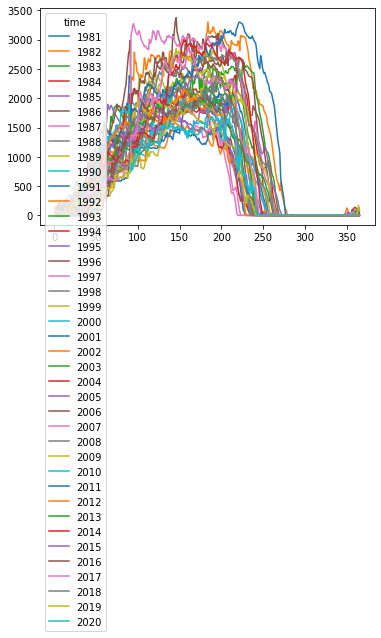

In [12]:
pv.plot()

In [13]:
hs_md = pv.median(axis=1)
hs_mn = pv.mean(axis=1)
hs_std=pv.std(axis=1)
hs_min = pv.min(axis=1)
hs_max = pv.max(axis=1)

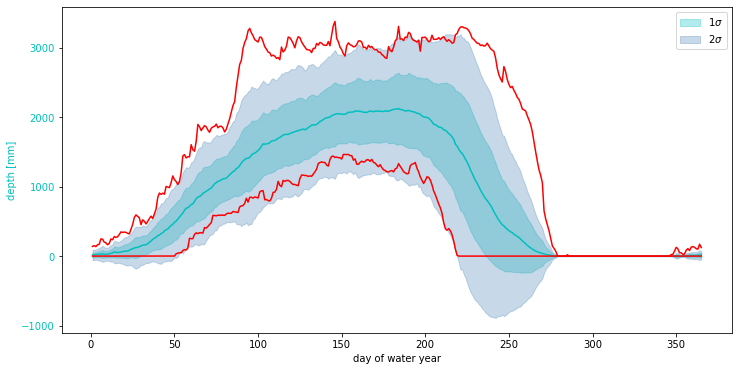

In [14]:
#plot results
fig, ax1 = plt.subplots(figsize=(12, 6))
color = 'c'
color2 = 'steelblue'
ax1.set_xlabel('day of water year')
ax1.set_ylabel('depth [mm]', color=color)
ax1.plot(pv.index.values,hs_mn, color=color)
ax1.plot(pv.index.values,hs_min, color='r')
ax1.plot(pv.index.values,hs_max, color='r')
ax1.fill_between(pv.index.values,hs_mn-hs_std, hs_mn+hs_std, color = color,alpha =0.3,label = r'1$\sigma$')
ax1.fill_between(pv.index.values,hs_mn-2*hs_std, hs_mn+2*hs_std, color = color2,alpha =0.3,label = r'2$\sigma$')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()
# ax2 = ax1.twinx()  
# color = 'c'
# ax2.set_ylabel('Fish [g/L]', color=color) 
# ax2.plot(times, yMedianF, color=color)
# ax2.fill_between(times, yLowerF, yUpperF, color = color,alpha =0.3)
# ax2.tick_params(axis='y', labelcolor=color)
# fig.tight_layout()  
# plt.show()

In [24]:
#calculate percentiles
p10 = pv.quantile(q=0.1, axis = 1)
p50 = pv.quantile(q=0.5, axis = 1)
p90 = pv.quantile(q=0.9, axis = 1) #eg 90th percentile confidence interval 

Text(0.5, 1.0, 'Hs 1982-2020')

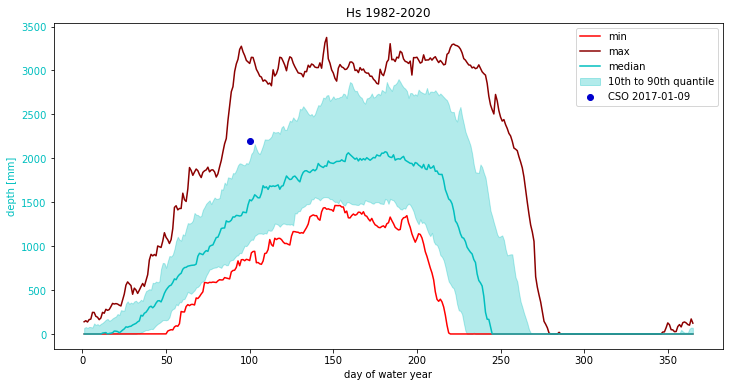

In [30]:
#plot results
fig, ax1 = plt.subplots(figsize=(12, 6))
color = 'c'
color2 = 'steelblue'
ax1.set_xlabel('day of water year')
ax1.set_ylabel('depth [mm]', color=color)
ax1.plot(pv.index.values,hs_min, color='r',label = 'min')
ax1.plot(pv.index.values,hs_max, color='darkred',label ='max')
ax1.plot(pv.index.values,p50, color=color,label='median')
ax1.fill_between(pv.index.values,p10, p90, color = color,alpha =0.3,label = r'10th to 90th quantile')
ax1.scatter(gdf.dowy[627],gdf.depth[627]*10,color='mediumblue',label='CSO '+str(gdf.dt[627]))
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()
ax1.set_title('Hs 1982-2020')
# ax2 = ax1.twinx()  
# color = 'c'
# ax2.set_ylabel('Fish [g/L]', color=color) 
# ax2.plot(times, yMedianF, color=color)
# ax2.fill_between(times, yLowerF, yUpperF, color = color,alpha =0.3)
# ax2.tick_params(axis='y', labelcolor=color)
# fig.tight_layout()  
# plt.show()

In [15]:
# add CSO data to plot 

# get cso doy 
gdf['dt'] = pd.to_datetime(gdf['timestamp'], format='%Y-%m-%dT%H:%M:%S')
gdf['dt'] = pd.to_datetime(gdf['dt']).dt.date
doy = pd.DatetimeIndex(gdf['dt']).dayofyear
wydoy = []
for value in doy:
    wydoy.append(get_wydoy(value))
gdf['dowy']=wydoy

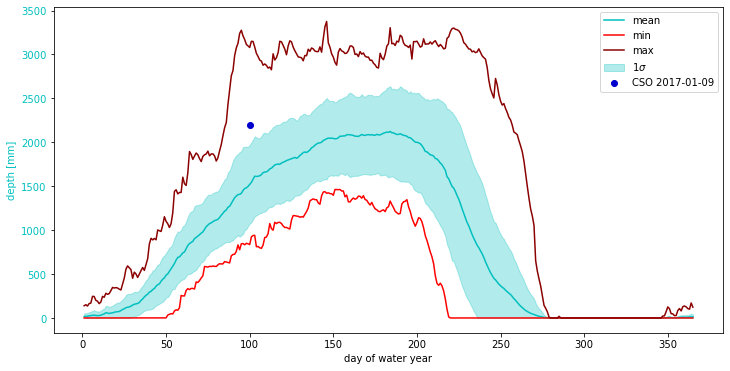

In [16]:
#plot results
fig, ax1 = plt.subplots(figsize=(12, 6))
color = 'c'
color2 = 'steelblue'
ax1.set_xlabel('day of water year')
ax1.set_ylabel('depth [mm]', color=color)
ax1.plot(pv.index.values,hs_mn, color=color,label = 'mean')
ax1.plot(pv.index.values,hs_min, color='r',label = 'min')
ax1.plot(pv.index.values,hs_max, color='darkred',label = 'max')
bot = hs_mn-hs_std
bot[bot<0]=0
ax1.fill_between(pv.index.values,bot, hs_mn+hs_std, color = color,alpha =0.3,label = r'1$\sigma$')
bot = hs_mn-2*hs_std
bot[bot<0]=0
#ax1.fill_between(pv.index.values,bot, hs_mn+2*hs_std, color = color2,alpha =0.3,label = r'2$\sigma$')
ax1.scatter(gdf.dowy[627],gdf.depth[627]*10,color='mediumblue',label='CSO '+str(gdf.dt[627]))
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()

In [141]:
gdf

,geometry,id,author,depth,source,timestamp,elevation,dt,dowy
0,POINT (-110.96955 43.50077),YvtYk5nZ,Grant Henarie,47.0,SnowPilot,2020-12-15T22:00:00.000Z,2583.323730,2020-12-15,76
1,POINT (-110.95316 43.49560),RHFMtCB0,Lynne Wolfe,89.0,SnowPilot,2020-12-15T20:00:00.000Z,2541.762939,2020-12-15,76
2,POINT (-110.83179 43.62928),vPeIuJm1,Nancy Bockino,90.0,SnowPilot,2020-12-15T19:00:00.000Z,2400.353760,2020-12-15,76
3,POINT (-110.87692 43.58721),4bMDgkOw,Dan Corn,115.0,SnowPilot,2020-12-15T16:50:00.000Z,2964.886963,2020-12-15,76
4,POINT (-110.87884 43.58034),N1WOeAD3,Tim Petrick,150.0,SnowPilot,2020-12-14T17:00:00.000Z,2878.567627,2020-12-14,75
...,...,...,...,...,...,...,...,...,...
627,POINT (-110.94512 43.50662),ZieRtWwG,Mike Hardaker,220.0,SnowPilot,2017-01-09T03:46:30.000Z,2681.205078,2017-01-09,100
628,POINT (-110.15553 44.46178),ZsTR7G2t,John McCurdy,165.0,SnowPilot,2016-12-23T17:46:29.000Z,2770.274658,2016-12-23,84
629,POINT (-110.87574 43.57965),Fqnv6kiF,Bill Anderson,142.0,SnowPilot,2016-12-21T13:28:18.000Z,2823.013916,2016-12-21,82
630,POINT (-110.87301 43.59553),t0HyUg9o,Mike Rheam,32.0,SnowPilot,2016-12-02T22:20:07.000Z,2997.033203,2016-12-02,63
